In [1]:
!rm -rf PsychRNN
!git clone https://github.com/murraylab/PsychRNN.git
%cd PsychRNN
!pip install -e .


Cloning into 'PsychRNN'...
remote: Enumerating objects: 628, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 628 (delta 82), reused 69 (delta 50), pack-reused 504 (from 1)
Receiving objects: 100% (628/628), 1.83 MiB | 14.97 MiB/s, done.
Resolving deltas: 100% (336/336), done.
/content/PsychRNN
Obtaining file:///content/PsychRNN
  Preparing metadata (setup.py) ... done
  Running setup.py develop for PsychRNN


Optimization finished!
Optimization finished!
delayed_clean Accuracy: 0.9141
Optimization finished!
Optimization finished!
delayed_noisy Accuracy: 0.7734
Optimization finished!
Optimization finished!
perceptual_clean Accuracy: 1.0000
Optimization finished!
Optimization finished!
perceptual_noisy Accuracy: 0.9766


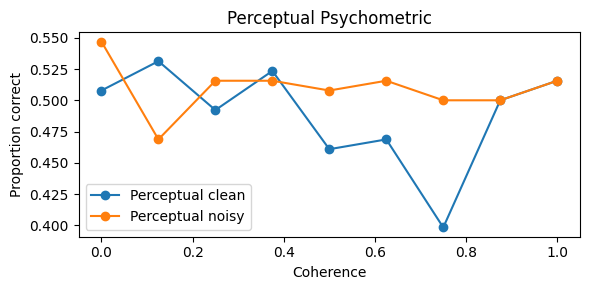

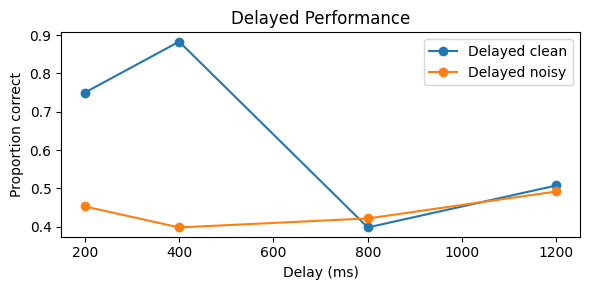

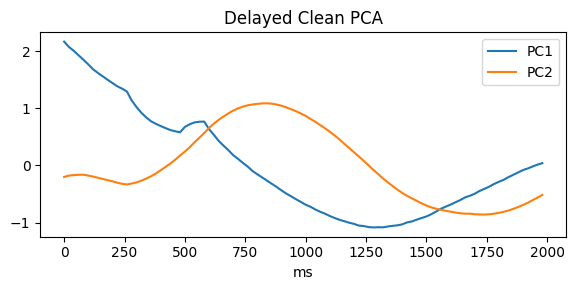

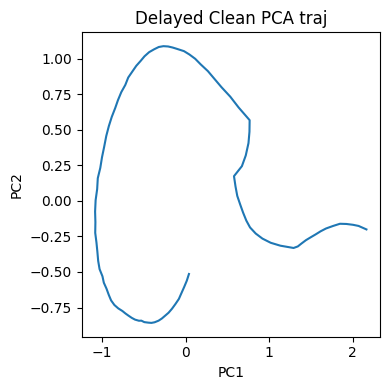

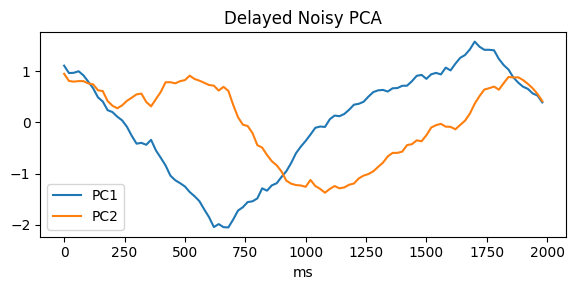

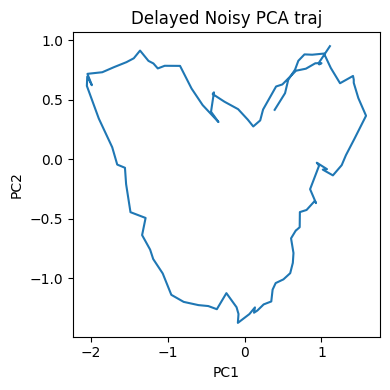

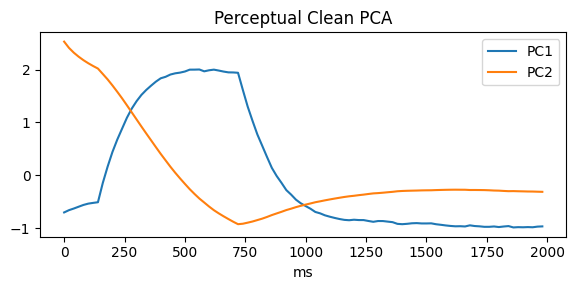

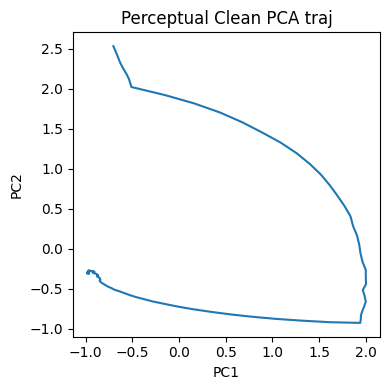

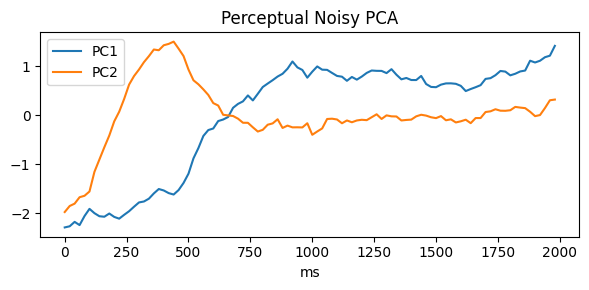

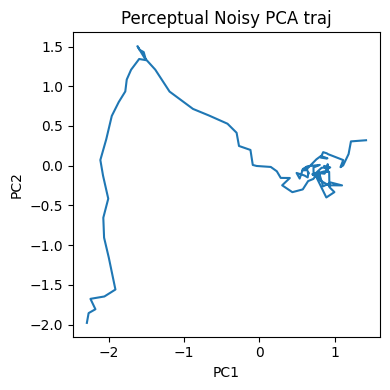

In [12]:
import os, sys, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA

tf.compat.v1.disable_eager_execution()
np.random.seed(0)
tf.compat.v1.set_random_seed(0)

os.makedirs("./trained_models", exist_ok=True)

from psychrnn.tasks.perceptual_discrimination import PerceptualDiscrimination
try:
    from psychrnn.tasks.delayed_discrim import DelayedDiscrimination
except Exception:
    from psychrnn.tasks.delayed_discrimination import DelayedDiscrimination

from psychrnn.backend.models.basic import Basic

def train_model(TaskClass, name, rec_noise=0.0, N_rec=100, batch=128, train_iters=15360, loss_epoch=320):
    tf.compat.v1.reset_default_graph()
    task = TaskClass(dt=20, tau=100, T=2000, N_batch=batch)
    params = task.get_task_params()
    params.update({
        "name": name,
        "N_rec": N_rec,
        "rec_noise": rec_noise,
        "save_path": f"./trained_models/{name}/"
    })
    os.makedirs(params["save_path"], exist_ok=True)
    model = Basic(params)
    train_params = {
        "training_iters": train_iters,
        "learning_rate": 1e-3,
        "loss_epoch": loss_epoch,
        "verbosity": True,
        "save_weights_path": None
    }
    try:
        ret = model.train(task, train_params)
    except Exception:
        ret = model.train(task.batch_generator(), train_params)
    if isinstance(ret, tuple) and len(ret) > 0:
        losses = np.array(ret[0], dtype=float)
    else:
        try:
            losses = np.array(ret, dtype=float)
        except Exception:
            losses = np.array([])
    try:
        model.save(os.path.join(params["save_path"], "final_weights.npz"))
    except Exception:
        pass
    return model, task, losses

def eval_accuracy(model, task):
    stim, targ, mask, _ = task.get_trial_batch()
    out = model.test(stim)
    preds = out[0] if isinstance(out, tuple) else out
    mask_bool = mask.astype(bool)
    ntr = targ.shape[0]
    avg_pred = np.zeros((ntr, targ.shape[-1]))
    avg_targ = np.zeros((ntr, targ.shape[-1]))
    for i in range(ntr):
        m = mask_bool[i]
        if m.any():
            if m.ndim == 2:
                rows = np.where(m.any(axis=1))[0]
            else:
                rows = np.where(m)[0]
            if rows.size == 0:
                sel_pred = preds[i, -1, :].reshape(1, -1)
                sel_targ = targ[i, -1, :].reshape(1, -1)
            else:
                sel_pred = preds[i, rows, :].reshape(-1, preds.shape[-1])
                sel_targ = targ[i, rows, :].reshape(-1, targ.shape[-1])
        else:
            sel_pred = preds[i, -1, :].reshape(1, -1)
            sel_targ = targ[i, -1, :].reshape(1, -1)
        avg_pred[i] = sel_pred.mean(0)
        avg_targ[i] = sel_targ.mean(0)
    acc = np.mean(np.argmax(avg_pred, axis=1) == np.argmax(avg_targ, axis=1))
    return acc, preds, out[1] if isinstance(out, tuple) and len(out) > 1 else None

def psychometric_perceptual(model, base_task, coherences, n_trials=128):
    props = []
    for c in coherences:
        t = PerceptualDiscrimination(dt=base_task.dt, tau=base_task.tau, T=base_task.T,
                                     N_batch=n_trials, coherence=float(c))
        x,y,m,_ = t.get_trial_batch()
        out = model.test(x)
        preds = out[0] if isinstance(out, tuple) else out
        final = np.argmax(preds[:, -1, :], axis=1)
        targ = np.argmax(y[:, -1, :], axis=1)
        props.append(np.mean(final == targ))
    return np.array(props)

def psychometric_delayed(model, base_task, delays, n_trials=128):
    props = []
    for d in delays:
        t = DelayedDiscrimination(dt=base_task.dt, tau=base_task.tau, T=base_task.T, N_batch=n_trials,
                                  onset_time=200, stim_duration_1=200, delay_duration=int(d),
                                  stim_duration_2=200, decision_duration=400)
        x,y,m,_ = t.get_trial_batch()
        out = model.test(x)
        preds = out[0] if isinstance(out, tuple) else out
        final = np.argmax(preds[:, -1, :], axis=1)
        targ = np.argmax(y[:, -1, :], axis=1)
        props.append(np.mean(final == targ))
    return np.array(props)

def run_psychometric(model_name, TaskClass, rec_noise, psychometric_fn, xvals, n_trials=128):

    tf.compat.v1.reset_default_graph()
    # create task with N_batch = n_trials to get params consistent
    task = TaskClass(dt=20, tau=100, T=2000, N_batch=n_trials)
    params = task.get_task_params()
    params.update({
        "name": model_name,
        "N_rec": 100,
        "rec_noise": rec_noise,
        "save_path": f"./trained_models/{model_name}/"
    })
    model = Basic(params)
    try:
        model.load(os.path.join(params["save_path"], "final_weights.npz"))
    except Exception:
        pass
    return psychometric_fn(model, task, xvals, n_trials)

def pca_plot_from_states(states, title):
    if states is None:
        print("No states available for PCA.")
        return
    trial_states = states[0]
    try:
        pcs = PCA(n_components=3).fit_transform(trial_states)
        t = np.arange(pcs.shape[0])*20
        plt.figure(figsize=(6,3)); plt.plot(t, pcs[:,0], label='PC1'); plt.plot(t, pcs[:,1], label='PC2'); plt.title(title); plt.xlabel('ms'); plt.legend(); plt.tight_layout(); plt.show()
        plt.figure(figsize=(4,4)); plt.plot(pcs[:,0], pcs[:,1]); plt.title(title+' traj'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.tight_layout(); plt.show()
    except Exception as e:
        print("PCA plotting failed:", e)

train_iters = 15360
N_rec = 100
batch = 128
rec_noise_clean = 0.0
rec_noise_noisy = 0.1
loss_epoch = 320

m_del_c, t_del_c, losses_del_c = train_model(DelayedDiscrimination, "delayed_clean",
                                             rec_noise_clean, N_rec, batch, train_iters, loss_epoch)
acc_del_c, preds_del_c, states_del_c = eval_accuracy(m_del_c, t_del_c)
print("Optimization finished!\ndelayed_clean Accuracy: {:.4f}".format(acc_del_c))

m_del_n, t_del_n, losses_del_n = train_model(DelayedDiscrimination, "delayed_noisy",
                                             rec_noise_noisy, N_rec, batch, train_iters, loss_epoch)
acc_del_n, preds_del_n, states_del_n = eval_accuracy(m_del_n, t_del_n)
print("Optimization finished!\ndelayed_noisy Accuracy: {:.4f}".format(acc_del_n))

m_per_c, t_per_c, losses_per_c = train_model(PerceptualDiscrimination, "perceptual_clean",
                                             rec_noise_clean, N_rec, batch, train_iters, loss_epoch)
acc_per_c, preds_per_c, states_per_c = eval_accuracy(m_per_c, t_per_c)
print("Optimization finished!\nperceptual_clean Accuracy: {:.4f}".format(acc_per_c))

m_per_n, t_per_n, losses_per_n = train_model(PerceptualDiscrimination, "perceptual_noisy",
                                             rec_noise_noisy, N_rec, batch, train_iters, loss_epoch)
acc_per_n, preds_per_n, states_per_n = eval_accuracy(m_per_n, t_per_n)
print("Optimization finished!\nperceptual_noisy Accuracy: {:.4f}".format(acc_per_n))

coherences = np.linspace(0.0, 1.0, 9)
delays = [200, 400, 800, 1200]

props_per_c = run_psychometric("perceptual_clean", PerceptualDiscrimination, rec_noise_clean,
                               psychometric_perceptual, coherences, n_trials=128)
props_per_n = run_psychometric("perceptual_noisy", PerceptualDiscrimination, rec_noise_noisy,
                               psychometric_perceptual, coherences, n_trials=128)

props_del_c = run_psychometric("delayed_clean", DelayedDiscrimination, rec_noise_clean,
                               psychometric_delayed, delays, n_trials=128)
props_del_n = run_psychometric("delayed_noisy", DelayedDiscrimination, rec_noise_noisy,
                               psychometric_delayed, delays, n_trials=128)

np.savez("psychometric_results.npz",
         coherences=coherences,
         perceptual_clean=props_per_c,
         perceptual_noisy=props_per_n,
         delays=delays,
         delayed_clean=props_del_c,
         delayed_noisy=props_del_n)

plt.figure(figsize=(6,3))
plt.plot(coherences, props_per_c, '-o', label='Perceptual clean')
plt.plot(coherences, props_per_n, '-o', label='Perceptual noisy')
plt.xlabel('Coherence'); plt.ylabel('Proportion correct'); plt.title('Perceptual Psychometric'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(delays, props_del_c, '-o', label='Delayed clean')
plt.plot(delays, props_del_n, '-o', label='Delayed noisy')
plt.xlabel('Delay (ms)'); plt.ylabel('Proportion correct'); plt.title('Delayed Performance'); plt.legend(); plt.tight_layout(); plt.show()

pca_plot_from_states(states_del_c, "Delayed Clean PCA")
pca_plot_from_states(states_del_n, "Delayed Noisy PCA")
pca_plot_from_states(states_per_c, "Perceptual Clean PCA")
pca_plot_from_states(states_per_n, "Perceptual Noisy PCA")

